## Clustering Toronto's Neighborhoods For Data Scientists Who Like To Party

### INTRODUCTION

This notebook is an attempt to segment the different neighborhoods in Toronto and see where one can find the best place to go if you want to party. It may also be interesting for a real estate developer, prospective club owner, a business person looking to better understand the cities neighborhoods, etc.

### DATA

The data for the problem comes from two main streams. The first stream is data scraped from a wiki page of toronto's different boroughs. To do this I use the beautiful soup library. The second stream of data is from the foursquare API and consists of using the latitude and longitude values of the different neighborhoods to import the different venue types that are within a specified radius of the lat,lon coordinates for that neighborhood

In [447]:
# webscraping
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as ureq
#!conda install requests
import requests
import json

import re

# for gathering latitude and longitude
from geopy.geocoders import Nominatim

# for progress bar (latitude, longitude processing is kind of slow)
from tqdm import tqdm

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors

# for accessing maps
#!conda install -c conda-forge folium=0.5.0 --yes
import folium

from sklearn.cluster import KMeans

In [448]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
src = requests.get(url).text

In [449]:
soup = soup(src, 'lxml')

In [450]:
table = soup.find('table', class_='wikitable sortable')

In [452]:
ls = []
for row in table.find_all('tr'):
    col = row.find_all('td')
    if len(col) == 3:
        ls.append((col[0].text.strip(), col[1].text.strip(), col[2].text.strip()))

In [453]:
df = pd.DataFrame(np.asarray(ls))
df.columns = ['PostalCode', 'Borough', 'Neighborhood']

df['Neighborhood'] = df['Neighborhood'].str.replace(']', '')

df.replace('Not assigned', np.nan, inplace=True)

df.head(10)

,PostalCode,Borough,Neighborhood
0,M1A,NaN,NaN
1,M2A,NaN,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,NaN
9,M8A,NaN,NaN


Handle situations like that of index 8 (PostalCode M7A) by setting the neighborhood equal to the borough if there code has a borough but there is no neighborhood in the wiki table.

In [454]:
for i in range(0, len(df.index)):
    if df.iloc[i,1] is not np.nan and df.iloc[i,2] is np.nan:
        df.iloc[i,2] = df.iloc[i,1]
df.head(10)

,PostalCode,Borough,Neighborhood
0,M1A,NaN,NaN
1,M2A,NaN,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Queen's Park
9,M8A,NaN,NaN


Get rid of Postal Codes from the wiki table that have NaN values 

In [460]:
df.dropna(inplace=True)
df = df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head(10)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [461]:
df.shape

(103, 3)

In [462]:
lats = []
lons = []
geolocator = Nominatim(user_agent="GeocodeEarth")
with tqdm(total=len(list(df.iterrows()))) as pbar:
    for index,row in df.iterrows():
        pbar.update(1)
        # handle special case that was not registering in geolocator's search
        if row['Borough'] == "Queen's Park":
            location = geolocator.geocode("Queen's Park, Toronto")
        else:
            # only use one neighborhood to look up the lat, lon coordinates
            location = geolocator.geocode(row['Neighborhood'].split(',')[0] + 
                                              ", " + row['Borough'] + ', Toronto')
            if location == None:
                location = geolocator.geocode(row['Borough'] + ', Toronto')
        #print(index, location.address)
        lats.append(location.latitude)
        lons.append(location.longitude)

100%|██████████| 103/103 [01:15<00:00,  1.64it/s]


In [463]:
df["Latitude"] = lats
df["Longitude"] = lons
df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.804930,-79.165837
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.790117,-79.173334
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.754899,-79.197776
3,M1G,Scarborough,Woburn,43.759824,-79.225291
4,M1H,Scarborough,Cedarbrae,43.756467,-79.226692
5,M1J,Scarborough,Scarborough Village,43.743742,-79.211632
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.707499,-79.266463
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.708823,-79.295986
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.721939,-79.236232
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.773077,-79.257774


In [464]:
location = geolocator.geocode("Toronto")
lat = location.latitude+.07
lon = location.longitude

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[lat, lon], zoom_start=10.5)

# add markers to map
for lat, lon, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], 
                                           df['Neighborhood']):
    # only use the first neighborhood to label on the map
    label = '{}, {}'.format(neighborhood.split(',')[0], borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### FOURSQUARE API
* [Foursquare](https://foursquare.com/) is a company with a massive dataset of accurate and comprehensive location data that power data for Apple Maps, Uber, Snapchat, Twitter, and others. The following cells access the foursquare developer API

* The developer API gives access to user data, aggregated or individual venue data, and allows for a variety of different types of queries to the foursquare database
    * For example, when doing a search query for an individual venue the API gives access to the venue's name, unique ID, location, category, available statistics, contact information, tips, ratings, and a URL. A search query for a user may give access to first name, last name, friends on foursquare, contact info, ID, tips, and gender. 
        * Note that some of these features may requires a premium account

* The following code uses the explore endpoint to query the foursquare database and gather information on multiple venues within a specified radius of the latitude and longitude found for each borough

TODO: check out the trending endpoint

### METHODOLOGY PART 1: Foursquare data exploration and finding the party

For each neighborhood, the following code accesses the foursquare database and collects the venues within a certain radius from latitude and longitude that was calculated earlier. It then formats the data so we can see the frequency with which each type of venue occurs in each neighborhood. Then it filters out venue types that are related to nightlife, like bars, clubs, and lounges for more refined analysis. After finding the party hubs by exploring the statistics of this data, I will segment the neighborhoods belonging to the set with the property of having the most of at least one type of party venue. This will give a good insight as to where the party hubs are located in relation to each other and how they compare and contrast. Then in the second part of the methodology section I will run the same analysis on the entire dataset and see how the kmeans algorithm segments the neighborhoods so that we can find party hubs we may have missed and/or refine our hypothesis about how the previously selected hubs deviate.

In [465]:
# The code was removed by Watson Studio for sharing.

In [466]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

venue_results = requests.get(url).json()

In [467]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [468]:
venues = venue_results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head() 

,name,categories,lat,lng
0,Starbucks,Coffee Shop,43.752496,-79.276393
1,Kim Kim restaurant,Chinese Restaurant,43.753833,-79.276611
2,Kairali,Indian Restaurant,43.754768,-79.277199
3,El Pulgarcito,Latin American Restaurant,43.754790,-79.277064
4,The Beer Store,Beer Store,43.750603,-79.276801


In [469]:
def getNearbyVenues(names, indices, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, hood_used_idx, lat, lng in zip(names, indices, latitudes, longitudes):
        name = name[hood_used_idx].strip()
        # print(name) 
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [470]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for names, lat, lng in zip(names, latitudes, longitudes):
        
        name = names.split(',')[0]
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # print(name)
        
        # handle empty requests
        if results == []:
            venues_list.append([(
            name, 
            lat, 
            lng, 
            None, 
            None, 
            None,  
            None)])
        
        else: 
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return nearby_venues

In [472]:
venues = getNearbyVenues(names=df['Neighborhood'],
                         latitudes=df['Latitude'],
                         longitudes=df['Longitude'])

In [473]:
# TEST: check sizes match for num unique neighborhoods in both dataframes
assert venues['Neighborhood'].nunique() == df['Neighborhood'].nunique()

In [474]:
# TEST: venue dataframe was properly constructed
# first neighborhood in df should match the neighborhood used to 
# look up venues to see which boroughs (if any) are causing problems
v=venues['Neighborhood'].unique()
d=df['Neighborhood'].unique()
for i in range(90,100):
    print(d[i], ' | ', v[i])

The Kingsway, Montgomery Road, Old Mill North  |  The Kingsway
Humber Bay, King's Mill Park, Kingsway Park South East, Mimico NE, Old Mill South, The Queensway East, Royal York South East, Sunnylea  |  Humber Bay
Kingsway Park South West, Mimico NW, The Queensway West, Royal York South West, South of Bloor  |  Kingsway Park South West
Islington Avenue  |  Islington Avenue
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park  |  Cloverdale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe  |  Bloordale Gardens
Humber Summit  |  Humber Summit
Emery, Humberlea  |  Emery
Weston  |  Weston
Westmount  |  Westmount


In [475]:
print(venues.shape, venues['Neighborhood'].nunique())
venues.head()

(3390, 7) 103


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rouge,43.804930,-79.165837,Dean Park,43.804364,-79.169159,Park
1,Rouge,43.804930,-79.165837,Paul's Breakfast & Burgers,43.803835,-79.169825,Fast Food Restaurant
2,Rouge,43.804930,-79.165837,I.D.A. - Pan Drugs,43.803432,-79.170692,Pharmacy
3,Highland Creek,43.790117,-79.173334,Highland Creek,43.790281,-79.173703,Neighborhood
4,Highland Creek,43.790117,-79.173334,Canmore Park,43.792401,-79.178339,Park


In [476]:
print('There are {} unique venue categories'.format(len(venues['Venue Category'].unique())))

There are 237 unique venue categories


In [477]:
venues[venues['Neighborhood']=="Rouge"]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rouge,43.80493,-79.165837,Dean Park,43.804364,-79.169159,Park
1,Rouge,43.80493,-79.165837,Paul's Breakfast & Burgers,43.803835,-79.169825,Fast Food Restaurant
2,Rouge,43.80493,-79.165837,I.D.A. - Pan Drugs,43.803432,-79.170692,Pharmacy


In [478]:
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
print(onehot.shape)
onehot.head()

(3390, 237)


,Accessories Store,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [479]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = ['Neighborhood'] + list(onehot.drop('Neighborhood', axis=1).columns)
onehot = onehot[fixed_columns]

print(onehot.shape)
onehot.head()

(3390, 237)


,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Rouge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rouge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rouge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Highland Creek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Highland Creek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Compute the occurence frequency of each venue type in each neighborhood

In [480]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
print(grouped.shape)
grouped.head()

(103, 237)


,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Adelaide,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,...,0.0,0.01,0.00000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00000,0.0,0.076923,0.0,0.0,0.00000,0.0,0.0
2,Agincourt North,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.03125,0.0,0.031250,0.0,0.0,0.03125,0.0,0.0
3,Albion Gardens,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
4,Alderwood,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0


In [481]:
test_neighborhood = "Agincourt"

g = grouped[grouped['Neighborhood'] == test_neighborhood].T.reset_index()[1:].sort_values(1, ascending=False)
g.rename(columns={1:"freq"}, inplace=True)
g[g["freq"] > 0]

,index,freq
44,Chinese Restaurant,0.230769
10,Asian Restaurant,0.153846
166,Peking Duck Restaurant,0.0769231
225,Train Station,0.0769231
81,Food Court,0.0769231
231,Vietnamese Restaurant,0.0769231
129,Korean Restaurant,0.0769231
49,Coffee Shop,0.0769231
112,Hong Kong Restaurant,0.0769231
185,Rental Car Location,0.0769231


In [482]:
num_top_venues = 5
num2print = 5

for hood in grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    num2print -= 1
    if num2print <= 0:
        break

----Adelaide----
                 venue  freq
0          Coffee Shop  0.07
1       Clothing Store  0.06
2           Restaurant  0.06
3  American Restaurant  0.04
4                 Café  0.04


----Agincourt----
                    venue  freq
0      Chinese Restaurant  0.23
1        Asian Restaurant  0.15
2  Peking Duck Restaurant  0.08
3           Train Station  0.08
4              Food Court  0.08


----Agincourt North----
                  venue  freq
0        Ice Cream Shop  0.06
1    Chinese Restaurant  0.06
2                Bakery  0.06
3  Fast Food Restaurant  0.06
4        Discount Store  0.03


----Albion Gardens----
                           venue  freq
0                   Dessert Shop   1.0
1  Paper / Office Supplies Store   0.0
2                  Moving Target   0.0
3                    Music Venue   0.0
4                     Nail Salon   0.0


----Alderwood----
            venue  freq
0     Pizza Place  0.22
1  Sandwich Place  0.11
2             Gym  0.11
3            Ban

In [483]:
def return_most_common_venues(row, num_top_venues):
    """sort venues in descending order"""
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # if the sorted frequencies have a zero before the number of venues
    # we want to return, we will fill those cells with 'NONE' so that we 
    # are not arbitrarily selecting venue types 
    zero_occurence_threshold = -1
    for i in range(num_top_venues):
        if row_categories_sorted[i] < 1e-7:
            zero_occurence_threshold = i
            break
    
    ret_val = np.array([])
    if zero_occurence_threshold == -1:  # there are 10 non-zero venue types
        ret_val = row_categories_sorted.index.values[0:num_top_venues]
    else:
        ret_val = row_categories_sorted.index.values[0:zero_occurence_threshold]
        for i in range(zero_occurence_threshold, num_top_venues):
            ret_val = np.append(ret_val, "NONE")
    
    return ret_val

In [484]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Clothing Store,Restaurant,American Restaurant,Café,Burger Joint,Cosmetics Shop,Tea Room,Theater,Plaza
1,Agincourt,Chinese Restaurant,Asian Restaurant,Peking Duck Restaurant,Korean Restaurant,Coffee Shop,Train Station,Rental Car Location,Food Court,Vietnamese Restaurant,Hong Kong Restaurant
2,Agincourt North,Ice Cream Shop,Bakery,Fast Food Restaurant,Chinese Restaurant,Indian Restaurant,Coffee Shop,Sporting Goods Shop,Spa,Shopping Mall,Sandwich Place
3,Albion Gardens,Dessert Shop,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,Alderwood,Pizza Place,Pub,Sandwich Place,Gym,Coffee Shop,Bank,Pool,Pharmacy,NONE,NONE


In [485]:
grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Adelaide,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,...,0.0,0.01,0.00000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00000,0.0,0.076923,0.0,0.0,0.00000,0.0,0.0
2,Agincourt North,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.03125,0.0,0.031250,0.0,0.0,0.03125,0.0,0.0
3,Albion Gardens,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
4,Alderwood,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0


In [486]:
grouped.describe()

,Accessories Store,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,...,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.000631,0.001022,0.003883,0.005825,0.016106,0.000347,0.000097,0.000097,0.001045,0.011330,...,0.005876,0.002946,0.001476,0.000511,0.005808,0.000313,0.014563,0.002768,0.000527,0.000846
std,0.003731,0.010372,0.039413,0.059120,0.025162,0.003519,0.000985,0.000985,0.004979,0.041777,...,0.029846,0.006824,0.007365,0.005186,0.017554,0.002392,0.102013,0.012138,0.003273,0.005682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.035625,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.027027,0.105263,0.400000,0.600000,0.090909,0.035714,0.010000,0.010000,0.035714,0.333333,...,0.166667,0.045455,0.050000,0.052632,0.105263,0.022222,1.000000,0.100000,0.027027,0.052632


In [487]:
for venue_type in grouped.T[1:].index:
    hood = grouped['Neighborhood'][grouped[venue_type].idxmax()]
    print("The most {}s are in {}".format(venue_type, hood))

The most Accessories Stores are in Don Mills North
The most Afghan Restaurants are in Thorncliffe Park
The most Airports are in Canada Post Gateway Processing Centre
The most Airport Terminals are in Canada Post Gateway Processing Centre
The most American Restaurants are in Humber Bay Shores
The most Antique Shops are in The Junction North
The most Art Gallerys are in Ryerson
The most Art Museums are in Christie
The most Arts & Crafts Stores are in The Junction North
The most Asian Restaurants are in Victoria Village
The most Athletics & Sportss are in Woodbine Heights
The most Auto Dealerships are in Newtonbrook
The most BBQ Joints are in The Annex
The most Bagel Shops are in Deer Park
The most Bakerys are in Humber Summit
The most Banks are in Alderwood
The most Bars are in Brockton
The most Baseball Fields are in Bathurst Manor
The most Beachs are in The Beaches
The most Beer Bars are in Little Portugal
The most Beer Stores are in Dorset Park
The most Big Box Stores are in Islington

Let's checkout where the nightlife venues are by filtering the venue types that contain the words "Club" or "Bar"

In [488]:
non_night_life_venues = [x for x in grouped.T[1:].index if not ("Club" in x or "Bar" in x or "Lounge" in x)]
night_life_df = grouped.drop(labels=non_night_life_venues, axis=1)
night_life_df.head()

,Neighborhood,Bar,Beer Bar,Cocktail Bar,Dive Bar,Gay Bar,Hookah Bar,Jazz Club,Juice Bar,Lounge,Piano Bar,Rock Club,Sake Bar,Salon / Barbershop,Sports Bar,Strip Club,Wine Bar
0,Adelaide,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.01000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agincourt,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Agincourt North,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Albion Gardens,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alderwood,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Although I suppose they could host a rad party, juice bars and salon/barbershops are not really what we are looking for...

In [489]:
night_life_df.drop(labels=['Juice Bar', 'Salon / Barbershop'], axis=1, inplace=True);

In [490]:
night_life_df.describe()

,Bar,Beer Bar,Cocktail Bar,Dive Bar,Gay Bar,Hookah Bar,Jazz Club,Lounge,Piano Bar,Rock Club,Sake Bar,Sports Bar,Strip Club,Wine Bar
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.010210,0.001769,0.000744,0.000996,0.000725,0.000097,0.001035,0.000841,0.000145,0.000145,0.000145,0.000522,0.000145,0.000313
std,0.027092,0.004167,0.006633,0.006210,0.007353,0.000985,0.006044,0.003858,0.001471,0.001471,0.001471,0.003078,0.001471,0.002392
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.157895,0.022222,0.066667,0.052632,0.074627,0.010000,0.052632,0.020833,0.014925,0.014925,0.014925,0.022222,0.014925,0.022222


In [491]:
d = {}
for idx, hood in zip(list(range(103)), night_life_df['Neighborhood']):
    d[idx] = hood.split(',')[0]

In [492]:
# for plotting a bar graph of venue types 
night_life_df2 = night_life_df.T.rename(columns=d)[1:]
night_life_df2.head()

,Adelaide,Agincourt,Agincourt North,Albion Gardens,Alderwood,Bathurst Manor,Bayview Village,Bedford Park,Berczy Park,Birch Cliff,...,Upper Rouge,Victoria Village,Westmount,Weston,Willowdale South,Willowdale West,Woburn,Woodbine Gardens,Woodbine Heights,York Mills West
Bar,0.01,0,0,0,0,0,0,0,0.01,0,...,0,0,0,0,0,0,0.05,0,0,0
Beer Bar,0.01,0,0,0,0,0,0,0,0.01,0,...,0,0,0,0,0,0,0,0,0,0
Cocktail Bar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dive Bar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gay Bar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


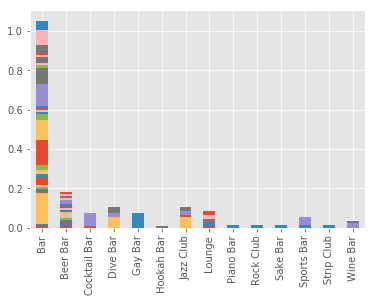

In [493]:
night_life_df2.plot.bar(stacked=True, legend=False)

Although the "Bar" venue type is in many neighborhoods as expected, there are definitely some neighborhoods with a disproprtionate amount. For the other types of venues there is usally one or a few neighborhoods. Lets find the top neighborhoods for these venue types and analyze them further. 

In [494]:
hot_spots = []
for venue_type in night_life_df.T[1:].index:
    hood = night_life_df['Neighborhood'][night_life_df[venue_type].idxmax()]
    hot_spots.append(hood)
    print("The most {}s are in {}".format(venue_type, hood))
hot_spots = list(set(hot_spots))

The most Bars are in Brockton
The most Beer Bars are in Little Portugal
The most Cocktail Bars are in Little Portugal
The most Dive Bars are in Brockton
The most Gay Bars are in Church and Wellesley
The most Hookah Bars are in Ryerson
The most Jazz Clubs are in Brockton
The most Lounges are in Willowdale South
The most Piano Bars are in Church and Wellesley
The most Rock Clubs are in Church and Wellesley
The most Sake Bars are in Church and Wellesley
The most Sports Bars are in Little Portugal
The most Strip Clubs are in Church and Wellesley
The most Wine Bars are in Little Portugal


In [495]:
hot_spots

['Little Portugal',
 'Church and Wellesley',
 'Willowdale South',
 'Ryerson',
 'Brockton']

In [496]:
def process(x):
    return x.split(',')[0]

In [497]:
hot_spot_df = df
hot_spot_df['Neighborhood'] = df['Neighborhood'].apply(process)
hot_spot_df = hot_spot_df[(hot_spot_df['Neighborhood'] == 'Little Portugal') | 
                          (hot_spot_df['Neighborhood'] == 'Church and Wellesley') | 
                          (hot_spot_df['Neighborhood'] == 'Willowdale South') | 
                          (hot_spot_df['Neighborhood'] == 'Ryerson') | 
                          (hot_spot_df['Neighborhood'] == 'Brockton')]

In [498]:
hot_spot_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
22,M2N,North York,Willowdale South,43.769814,-79.413810
52,M4Y,Downtown Toronto,Church and Wellesley,43.662276,-79.376203
54,M5B,Downtown Toronto,Ryerson,43.658153,-79.379080
77,M6J,West Toronto,Little Portugal,43.649631,-79.431433
78,M6K,West Toronto,Brockton,43.650989,-79.440029


In [499]:
location = geolocator.geocode("Toronto")
lat = location.latitude+.05
lon = location.longitude

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[lat, lon], zoom_start=11)

# add markers to map
for lat, lon, borough, neighborhood in zip(hot_spot_df['Latitude'], hot_spot_df['Longitude'], 
                                           hot_spot_df['Borough'], hot_spot_df['Neighborhood']):
    # only use the first neighborhood to label on the map
    label = '{}, {}'.format(neighborhood.split(',')[0], borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Looking at the map above we can see that it looks like there are two main hubs close to the city center for night life in Toronto, West Town (Brockton and Little Portugal) and Downtown (Ryerson and Church and Wellesley), and potentially one in North York. Maybe North York is where all the cool kids hang out because apparently the Willowdale South neighborhood is the lounge hub of Toronto. Let's see if kmeans clustering segments the two geopraphically isolated clusters in the city center the same way based on venue type data by using a dataset that filters out only these four neighborhoods and segments them into the two distinct pairs of places to go out and party. If it does, this will also give us some insight about what type of place Willowdale South is, because it will be sorted into one of the two clusters.

In [500]:
hot_spot_grouped_df = grouped
hot_spot_grouped_df['Neighborhood'] = grouped['Neighborhood'].apply(process)
hot_spot_grouped_df = hot_spot_grouped_df[(hot_spot_grouped_df['Neighborhood'] == 'Little Portugal') | 
                          (hot_spot_grouped_df['Neighborhood'] == 'Church and Wellesley') |
                          (hot_spot_grouped_df['Neighborhood'] == 'Willowdale South') |
                          (hot_spot_grouped_df['Neighborhood'] == 'Ryerson') | 
                          (hot_spot_grouped_df['Neighborhood'] == 'Brockton')]
hot_spot_grouped_df

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
11,Brockton,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.105263,0.000000,0.0,0.000000,0.0,0.0
22,Church and Wellesley,0.0,0.0,0.0,0.0,0.029851,0.0,0.00,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
65,Little Portugal,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,...,0.0,0.022222,0.0,0.0,0.044444,0.022222,0.0,0.000000,0.0,0.0
80,Ryerson,0.0,0.0,0.0,0.0,0.020000,0.0,0.01,0.0,0.000000,...,0.0,0.010000,0.0,0.0,0.010000,0.010000,0.0,0.000000,0.0,0.0
97,Willowdale South,0.0,0.0,0.0,0.0,0.020833,0.0,0.00,0.0,0.020833,...,0.0,0.000000,0.0,0.0,0.020833,0.000000,0.0,0.020833,0.0,0.0


In [501]:
hot_spot_grouped_clustering = hot_spot_grouped_df.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(hot_spot_grouped_clustering)

for hood, label in zip(hot_spot_grouped_df['Neighborhood'], kmeans.labels_):
    print("{} is in group {}".format(hood, label))

Brockton is in group 1
Church and Wellesley is in group 0
Little Portugal is in group 1
Ryerson is in group 0
Willowdale South is in group 0


Nice! As expected, the geographic clusters of party spots are seperated in the same way by kmeans based on venue type data. Now let's see what kinds of venues are common to both neighborhoods of each cluster.

In [502]:
cluster_0_df = hot_spot_grouped_df[(hot_spot_grouped_df['Neighborhood'] == 'Church and Wellesley') | 
                                   (hot_spot_grouped_df['Neighborhood'] == 'Willowdale South') |
                                   (hot_spot_grouped_df['Neighborhood'] == 'Ryerson')]

cluster_1_df = hot_spot_grouped_df[(hot_spot_grouped_df['Neighborhood'] == 'Brockton') | 
                                   (hot_spot_grouped_df['Neighborhood'] == 'Little Portugal')]

In [503]:
common_cluster_0 = cluster_0_df.describe().T['min']
common_cluster_0[common_cluster_0 > 0]

American Restaurant     0.020000
Café                    0.029851
Coffee Shop             0.083333
Fast Food Restaurant    0.010000
Grocery Store           0.010000
Hotel                   0.010000
Japanese Restaurant     0.020833
Lounge                  0.014925
Movie Theater           0.020000
Pizza Place             0.014925
Ramen Restaurant        0.020000
Sandwich Place          0.014925
Supermarket             0.010000
Theater                 0.010000
Name: min, dtype: float64

In [504]:
common_cluster_1 = cluster_1_df.describe().T['min']
common_cluster_1[common_cluster_1 > 0]

Bakery                   0.052632
Bar                      0.111111
Café                     0.088889
Coffee Shop              0.052632
Dive Bar                 0.022222
French Restaurant        0.022222
Gastropub                0.022222
Grocery Store            0.022222
Jazz Club                0.022222
Portuguese Restaurant    0.022222
Vietnamese Restaurant    0.044444
Name: min, dtype: float64

So we can see that the kmeans algorithm segmented the two clusters in the city center as we expected. The cluster with Brockton and Little Portugal appears to be a lot of bars and restaurants. The other downtown cluster appears to have more upscale venues, like theaters, lounges, and hotels. This is also where the algorithm chose to place Willowdale South, which is not surprising because as we can see two cells above, there are many common venue types in all three of the neighborhoods in this cluster.

### METHODOLOGY PART 2: K-means clustering on all neighborhoods

Let's go back to the entire dataset and see if we can run kmeans again. Then we can look to see what clusters the 5 neighborhoods we have already analyzed are placed into and potentially formulate some new hypothesis about other regions of Toronto. The data is processed into an occurence frequency table for each neighborhood and venue type, so like with the smaller set of neighborhoods we can run a clustering algorithm to find structure in the data and sort like types of neighborhoods together. The next cell will run the K-means clustering algorithms for different values of k. The algorithm partitions the data into k clusters by repeating the process of choosing a centroid for each cluster, finding the distance from each point to each cluster, assigning that point to the closest cluster, and then relocating each centroid (cluster center) by taking the mean of all data points assigned to that cluster at the current iteration. This will be done for a specified amount of k values so we can plot them and see what may be a good k value to select. 

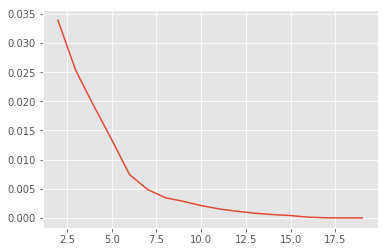

In [531]:
# set number of clusters
max_clusters = 20

night_life_clustering = night_life_df.drop(['Neighborhood', 'Latitude', 'Longitude'],1)

# within cluster some of squares
wcss = []

for k in range(2, max_clusters):

    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(night_life_clustering)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(2,max_clusters), wcss)

### RESULTS: Building the model by selecting K via the ELBO method

The metric we want to optimize is a minimization of the within cluster some of squares (i.e. variance), which corresponds to maximizing the between-cluster sum of squares. In the graph above it looks like the within cluster sum of squares is reaching a point of diminishing returns around k=6, so I will choose that as the k-value.

[0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 5 2 0 0 0 0 0 0 0 0 0 0 5 0 1 0
 0 0 1 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 5 0 0 0 0 0 0 5 0 0 1 0 0 0 0 0 0 0 0 5 0 0 0]


(array([ 90.,   0.,   4.,   0.,   1.,   0.,   1.,   0.,   1.,   6.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 10 Patch objects>)

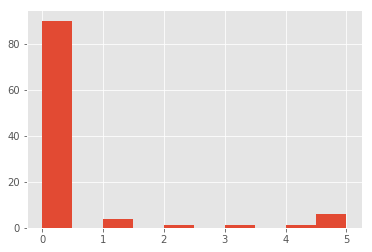

In [532]:
kclusters=6

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(night_life_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_) 

plt.hist(kmeans.labels_)

In [533]:
night_life_df['Cluster Label'] = kmeans.labels_

# get the first neighborhood for each 
df['Neighborhood'] = df['Neighborhood'].apply(lambda x: x.split(',')[0])

# add lats and lons to each neighborhood
night_life_df = night_life_df.join(df.set_index('Neighborhood').drop(['PostalCode', 'Borough'], 1), 
                                   on='Neighborhood')

night_life_df.head()

,Neighborhood,Bar,Beer Bar,Cocktail Bar,Dive Bar,Gay Bar,Hookah Bar,Jazz Club,Lounge,Piano Bar,Rock Club,Sake Bar,Sports Bar,Strip Club,Wine Bar,Latitude,Longitude,Cluster Label
0,Adelaide,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.654027,-79.380200,0
1,Agincourt,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.785353,-79.278549,0
2,Agincourt North,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.808038,-79.266439,0
3,Albion Gardens,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.750011,-79.637342,0
4,Alderwood,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.601717,-79.545232,0


In [534]:
merged = df.groupby("Neighborhood").mean().reset_index() 

# add clustering labels
merged['Cluster Label'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged = merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

print(merged.shape)

merged.head() # check the last columns!

(103, 14)


,Neighborhood,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,43.654027,-79.380200,0,Coffee Shop,Clothing Store,Restaurant,American Restaurant,Café,Burger Joint,Cosmetics Shop,Tea Room,Theater,Plaza
1,Agincourt,43.785353,-79.278549,0,Chinese Restaurant,Asian Restaurant,Peking Duck Restaurant,Korean Restaurant,Coffee Shop,Train Station,Rental Car Location,Food Court,Vietnamese Restaurant,Hong Kong Restaurant
2,Agincourt North,43.808038,-79.266439,0,Ice Cream Shop,Bakery,Fast Food Restaurant,Chinese Restaurant,Indian Restaurant,Coffee Shop,Sporting Goods Shop,Spa,Shopping Mall,Sandwich Place
3,Albion Gardens,43.750011,-79.637342,0,Dessert Shop,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,Alderwood,43.601717,-79.545232,0,Pizza Place,Pub,Sandwich Place,Gym,Coffee Shop,Bank,Pool,Pharmacy,NONE,NONE


In [535]:
# create map
location = geolocator.geocode("Toronto")
lat = location.latitude+0.05
lon = location.longitude

map_clusters = folium.Map(location=[lat, lon], zoom_start=10.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [matplotlib.colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(night_life_df['Latitude'], night_life_df['Longitude'],
                                  night_life_df['Neighborhood'], night_life_df['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### DISCUSSION / CLUSTER ANALYSIS

The results show that almost all of the neighborhoods belong to the same cluster (Cluster 0), which is the one with almost no clubs, bars, or lounges. What I find interesting is that apart from Willowdale South which has only a lounge (it actually belongs to the Cluster 0, the boring cluster), three of the other four neighborhoods that were analyzed in the smaller segmentation are now their own distinct cluster. This sort of proves that not only do they each have the most of at least one type night life venue type but they are actually significant outliers relative to any other city areas. Let's check the distribution numerically. 

In [536]:
night_life_df['Cluster Label'].value_counts()

0    90
5     6
1     4
4     1
3     1
2     1
Name: Cluster Label, dtype: int64

Cluster 0 is where most neighborhoods go. Cluster 2 is Church and Wellesley by itself, which is not surprising given the amount of unique venue types for night life that it hosts. Brockton and Little Portugal are also their own clusters, numbers 3 and 4 respectively. Ryerson is apart of cluster 1, which as you can see in the filtered dataframe below seems to have included some neighborhoods that should not really be lumped in with the party districts. 

In [537]:
night_life_df.loc[night_life_df['Cluster Label'] == 5, 
                  night_life_df.columns[[0] + list(range(3, night_life_df.shape[1]))]].tail(10)

,Neighborhood,Cocktail Bar,Dive Bar,Gay Bar,Hookah Bar,Jazz Club,Lounge,Piano Bar,Rock Club,Sake Bar,Sports Bar,Strip Club,Wine Bar,Latitude,Longitude,Cluster Label
21,Christie,0.01,0.0,0.0,0.00,0.010000,0.01,0.0,0.0,0.0,0.0,0.0,0.00,43.649991,-79.385722,5
33,Don Mills North,0.00,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.00,43.737178,-79.343451,5
40,East Toronto,0.00,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.00,43.670862,-79.372792,5
80,Ryerson,0.00,0.0,0.0,0.01,0.000000,0.02,0.0,0.0,0.0,0.0,0.0,0.01,43.658153,-79.379080,5
87,The Beaches,0.00,0.0,0.0,0.00,0.021739,0.00,0.0,0.0,0.0,0.0,0.0,0.00,43.671024,-79.296712,5
99,Woburn,0.00,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.00,43.759824,-79.225291,5


### CONCLUSION

The places to go seem to be either of the two clusters that we previously analyzed in the smaller kmeans model. Either to hit the bars and/or grab a bite to eat near the airport in Little Portugal or Brockton. The other downtown cluster seems to be the place for clubbing as we may expect, and also appears to be a bit more upscale than its cross town party-hub counterpart. 
